In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import thinkstats2
from statsmodels.stats.power import TTestPower

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,8)

# Covid Death Rates in Murica

Use this data to attempt the analysis below. 

In [2]:
df = pd.read_csv("data/covid_deaths.csv")
df.head()

,Day,unvaccinated,fully_vaccinated,one_booster,two_boosters
0,2022-04-02,2.405073,0.384576,0.269884,0.290136
1,2022-04-09,2.342870,0.366587,0.324628,0.695672
2,2022-04-16,2.349217,0.451211,0.346906,0.230545
3,2022-04-23,2.454704,0.516000,0.546689,0.062556
4,2022-04-30,3.308662,0.637330,0.681762,0.259442


<AxesSubplot:xlabel='Day', ylabel='unvaccinated'>

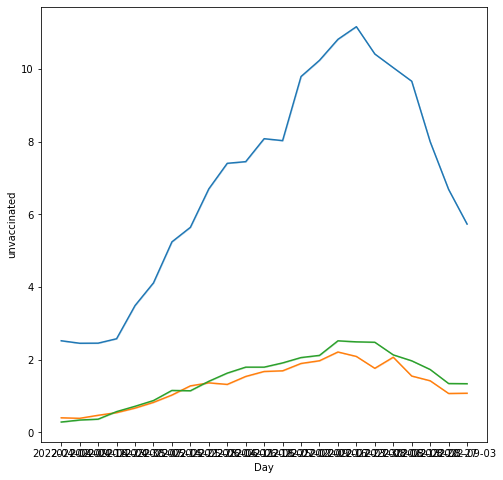

In [3]:
sns.lineplot(data=df, x="Day", y="unvaccinated", ci=0)
sns.lineplot(data=df, x="Day", y="fully_vaccinated", ci=0)
sns.lineplot(data=df, x="Day", y="one_booster", ci=0)

## Is there a significant difference in death rates between Fully Vaccinated people and Unvaccinated people?

#### Create Datasets

In [4]:
fv = df["fully_vaccinated"]
un = df["unvaccinated"]

#### Explore Datasets

<AxesSubplot:xlabel='fully_vaccinated', ylabel='Density'>

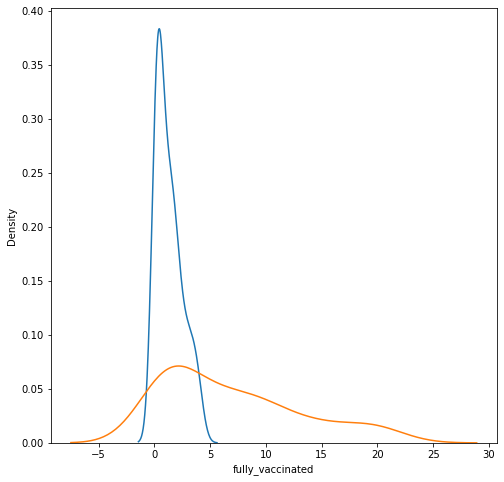

In [5]:
sns.kdeplot(fv)
sns.kdeplot(un)

In [6]:
fv.describe()

count    69.000000
mean      1.318059
std       1.148704
min       0.044441
25%       0.297390
50%       1.025216
75%       1.966681
max       4.136138
Name: fully_vaccinated, dtype: float64

In [7]:
un.describe()

count    69.000000
mean      6.903453
std       6.116893
min       0.377413
25%       1.357448
50%       5.367513
75%      10.284717
max      21.037893
Name: unvaccinated, dtype: float64

### Hypothesis Test

First I'll try a regular t-test, then I'll do the non-parametric version, the Mann-Whitney. 

In [8]:
# t-test
ss.ttest_ind(fv, un)

Ttest_indResult(statistic=-7.454552636718715, pvalue=9.50701441183468e-12)

In [9]:
# mw
ss.mannwhitneyu(fv, un)

MannwhitneyuResult(statistic=845.0, pvalue=6.299258240567537e-11)

### Calculate Power

In [10]:
# Calculate inputs
ces = thinkstats2.CohenEffectSize(un, fv)
alpha = .05
nobs = fv.count() + un.count()

In [11]:
# calculate power
powerTest = TTestPower()
pow = powerTest.power(effect_size=ces, nobs=nobs, alpha=alpha)
pow, ces

(1.0, 1.2691473231783308)

### Result

Looks like a statistically significant difference, by every metric. 

## Is There a Significant Difference in Death Rates Between Fully Vaccinated and Boosted Populations*

*The boosted population has two groups - those with one booster and those with two. The one booster group is larger than the two booster group - there are more people with only one booster than there are with two. Use the below ratio to generate a weighted average rate. I.e. if the ratio is .2, that means that 20% of the total boosted population has two doses and 80% have one dose. 

In [12]:
two_dose_ratio = .2

In [13]:
b1 = df["one_booster"]
b2 = df["two_boosters"]
boost = (b1 * (1 - two_dose_ratio)) + (b2 * two_dose_ratio)
boost

0     0.273934
1     0.398837
2     0.323634
3     0.449862
4     0.597298
        ...   
64    3.566121
65    3.163846
66    2.930213
67    2.260076
68    2.290633
Length: 69, dtype: float64

#### Explore

<AxesSubplot:xlabel='fully_vaccinated', ylabel='Density'>

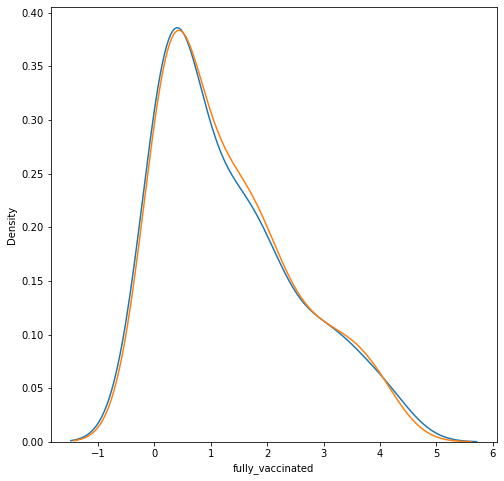

In [14]:
sns.kdeplot(boost)
sns.kdeplot(fv)

#### Test

In [15]:
# t-test
print(ss.ttest_ind(fv, boost))
# mw
print(ss.mannwhitneyu(fv, boost))

Ttest_indResult(statistic=0.08839172910537565, pvalue=0.929695361047642)
MannwhitneyuResult(statistic=2440.0, pvalue=0.8016297416888358)


#### Power

In [16]:
# Calculate inputs
ces2 = thinkstats2.CohenEffectSize(fv, boost)
alpha2 = .05
nobs2 = fv.count() + boost.count()
# calculate power
powerTest2 = TTestPower()
pow2 = powerTest.power(effect_size=ces2, nobs=nobs2, alpha=alpha2)
pow2, ces2

(0.05353763977604623, 0.01504880733320184)

#### How Large of a Sample is Needed for a Power of .8?

In [17]:
need_samp = powerTest2.solve_power(alpha=.05, effect_size=ces2, power=.8)
need_samp, nobs2

(34659.83744287985, 138)

#### More Sophisticated Rates

We can improve the approximation of the number of people with two boosters vs one booster. For this part, try to consider the following, and put this into your data:
<ul>
<li> There is a starting rate of two booster people (similar to above - the proportion of boosted people with 2 boosters). Try this being <b>.1</b>
<li> There is a final rate of two booster people. Try with this being <b>.3</b>
<li> Each day, the ratio of people with boosters who have two increases a set amount, starting with the first value (.1) on day 1, and the last (.3) on the last day. 
</ul>

<b>Note:</b> This is more of a challenge of manipulating the data than of the hypothesis testing. Once the datasets are established, the process is the same as above. The function "np.arrange" may be useful here, but there's probably lots of ways to do it. 

In [18]:
# Plot Ratios
start = .1
cap = .3
increment = (cap - start)/len(df)

x = np.arange(start, cap, increment)
x

array([0.1       , 0.10289855, 0.1057971 , 0.10869565, 0.1115942 ,
       0.11449275, 0.1173913 , 0.12028986, 0.12318841, 0.12608696,
       0.12898551, 0.13188406, 0.13478261, 0.13768116, 0.14057971,
       0.14347826, 0.14637681, 0.14927536, 0.15217391, 0.15507246,
       0.15797101, 0.16086957, 0.16376812, 0.16666667, 0.16956522,
       0.17246377, 0.17536232, 0.17826087, 0.18115942, 0.18405797,
       0.18695652, 0.18985507, 0.19275362, 0.19565217, 0.19855072,
       0.20144928, 0.20434783, 0.20724638, 0.21014493, 0.21304348,
       0.21594203, 0.21884058, 0.22173913, 0.22463768, 0.22753623,
       0.23043478, 0.23333333, 0.23623188, 0.23913043, 0.24202899,
       0.24492754, 0.24782609, 0.25072464, 0.25362319, 0.25652174,
       0.25942029, 0.26231884, 0.26521739, 0.26811594, 0.27101449,
       0.27391304, 0.27681159, 0.27971014, 0.2826087 , 0.28550725,
       0.2884058 , 0.29130435, 0.2942029 , 0.29710145])

In [19]:
# Add ratio to df
df["Ratio"] = x
df.head()

,Day,unvaccinated,fully_vaccinated,one_booster,two_boosters,Ratio
0,2022-04-02,2.405073,0.384576,0.269884,0.290136,0.100000
1,2022-04-09,2.342870,0.366587,0.324628,0.695672,0.102899
2,2022-04-16,2.349217,0.451211,0.346906,0.230545,0.105797
3,2022-04-23,2.454704,0.516000,0.546689,0.062556,0.108696
4,2022-04-30,3.308662,0.637330,0.681762,0.259442,0.111594


In [20]:
# Generate Weighted Boosted Rate

In [21]:
df["WeightBoost"] = (df["one_booster"] * (1-df["Ratio"])) + (df["two_boosters"] * df["Ratio"])
df.sample(10)

,Day,unvaccinated,fully_vaccinated,one_booster,two_boosters,Ratio,WeightBoost
9,2022-06-04,7.035629,1.251821,1.553023,0.640155,0.126087,1.437922
50,2022-04-30,6.786848,1.223622,1.360174,0.297333,0.244928,1.099855
11,2022-06-18,7.689546,1.592991,1.708276,0.557898,0.131884,1.556559
56,2022-06-11,14.140804,2.871950,3.460343,1.163142,0.262319,2.857744
40,2022-07-30,1.585841,0.254973,0.400061,0.164549,0.215942,0.349204
47,2022-04-09,4.458317,0.748841,0.598523,0.869313,0.236232,0.662493
61,2022-07-16,20.533653,4.136138,4.679928,1.633942,0.276812,3.836764
1,2022-04-09,2.342870,0.366587,0.324628,0.695672,0.102899,0.362808
36,2022-07-02,1.339094,0.298481,0.313206,0.032640,0.204348,0.255873
20,2022-08-20,7.591126,1.348963,1.640796,0.651797,0.157971,1.484563


In [22]:
wboost = df["WeightBoost"]

### Do Test

In [23]:
# t-test
print(ss.ttest_ind(fv, wboost))
# mw
print(ss.mannwhitneyu(fv, wboost))

Ttest_indResult(statistic=0.22626533389464973, pvalue=0.8213347682947116)
MannwhitneyuResult(statistic=2445.0, pvalue=0.7852146286001633)


#### Power

In [24]:
# Calculate inputs
ces3 = thinkstats2.CohenEffectSize(fv, wboost)
alpha3 = .05
nobs3 = fv.count() + wboost.count()
# calculate power
powerTest3 = TTestPower()
pow3 = powerTest.power(effect_size=ces3, nobs=nobs3, alpha=alpha3)
pow3, ces3

(0.07343642074566771, 0.03852196863242589)

## ANOVA

Is there a significant difference between any of the 3 vaccinated groups? Can you test it? 

In [25]:
#First, test for vars being equal-ish
varStat, varP = ss.levene(df['fully_vaccinated'],
               df['one_booster'],
               df['two_boosters'])
varP

2.559442889524628e-09

In [26]:
df["fully_vaccinated"].var(), df["one_booster"].var(), df["two_boosters"].var()

(1.3195206562272244, 1.8526001242998276, 0.23117763061071334)

It appears that the two boosters one has a radically different varaiance, that will make our ANOVA not really reliable. 